In [2]:
import codecs
import pathlib
import re
from tqdm import tqdm

In [4]:
DOW_30_2010 = [
    '3M CO',
    'DOW CHEMICAL CO /DE/',
    'MCDONALDS CORP',
    'ALCOA INC',
    'EXXON MOBIL CORP',
    'Merck & Co. Inc.',
    'AMERICAN EXPRESS CO',
    'GENERAL ELECTRIC CO',
    'MICROSOFT CORP',
    'AT&T INC.',
    'HEWLETT PACKARD CO',
    'PFIZER INC',
    'BANK OF AMERICA CORP /DE/',
    'HOME DEPOT INC',
    'PROCTER & GAMBLE CO',
    'BOEING CO',
    'INTEL CORP',
    'TRAVELERS COMPANIES, INC.',
    'CATERPILLAR INC',
    'INTERNATIONAL BUSINESS MACHINES CORP',
    'UNITED TECHNOLOGIES CORP /DE/',
    'CHEVRON CORP',
    'JOHNSON & JOHNSON',
    'VERIZON COMMUNICATIONS INC',
    'CISCO SYSTEMS INC',
    'J P MORGAN CHASE & CO',
    'WAL MART STORES INC',
    'COCA COLA CO',
    'KRAFT FOODS INC',
    'WALT DISNEY CO/',
]

DOW_30_CHANGES = {
    2012: {
        'in': ['UNITEDHEALTH GROUP INC', 'JPMORGAN CHASE & CO', 'CISCO SYSTEMS, INC.', 'PROCTER & GAMBLE Co'],
        'out': ['KRAFT FOODS INC', 'J P MORGAN CHASE & CO', 'CISCO SYSTEMS INC', 'PROCTER & GAMBLE CO']
    },
    2013: {
        'in': ['GOLDMAN SACHS GROUP INC', 'VISA INC.', 'NIKE INC'], 
        'out': ['ALCOA INC', 'BANK OF AMERICA CORP /DE/', 'HEWLETT PACKARD CO']
    },
    2015: {
        'in': ['APPLE INC', 'Merck & Co., Inc.'],
        'out': ['AT&T INC.', 'Merck & Co. Inc.']
    },
    2018: {
        'in': ['Walgreens Boots Alliance, Inc.', 'Walmart Inc.'],
        'out': ['GENERAL ELECTRIC CO', 'WAL MART STORES INC']
    },
    2019: {
        'in': ['Apple Inc.', 'Walt Disney Co'],
        'out': ['APPLE INC', 'WALT DISNEY CO/']
    },
    2020: {
        'in': ['SALESFORCE.COM, INC.', 'AMGEN INC', 'HONEYWELL INTERNATIONAL INC', 'DOW INC.', 'HOME DEPOT, INC.', 'NIKE, Inc.'],
        'out': ['EXXON MOBIL CORP', 'PFIZER INC', 'UNITED TECHNOLOGIES CORP /DE/', 'DOW CHEMICAL CO /DE/', 'HOME DEPOT INC', 'NIKE INC']
    }
}

def generate_dow_30(year):
    dow_30 = DOW_30_2010.copy()
    for y in range(2012, year + 1):
        if y in DOW_30_CHANGES:
            for company in DOW_30_CHANGES[y]['in']:
                dow_30.append(company)
            for company in DOW_30_CHANGES[y]['out']:
                dow_30.remove(company)
    return dow_30

In [3]:
import concurrent.futures
import pathlib
import codecs
import re

def process_year(year, pattern, dow_30, folders, root):
    for folder in folders:
        path = pathlib.Path(f'{root}/{year}/{folder}')
        for file in path.iterdir():
            with codecs.open(file, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
                match = re.search(pattern, content)
                if match:
                    name = match.group(1).strip()
                    if name in dow_30:
                        output_dir = pathlib.Path(f'clean_data/{year}/{name}')
                        output_dir.mkdir(parents=True, exist_ok=True)
                        output_file = output_dir / f'{file.name}.txt'
                        with codecs.open(output_file, 'w', encoding='utf-8', errors='ignore') as out_f:
                            out_f.write(content)
                        

pattern = r"COMPANY CONFORMED NAME:\s*(.+)"
root = 'SEC10X'
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
folders = ['QTR1_10-K_files', 'QTR2_10-K_files', 'QTR3_10-K_files', 'QTR4_10-K_files']

with concurrent.futures.ThreadPoolExecutor(max_workers=len(years)) as executor:
    future_to_year = {executor.submit(process_year, year, pattern, generate_dow_30(int(year)), folders, root): year for year in years}

NameError: name 'generate_dow_30' is not defined

In [5]:
def get_matches(pattern, text):
    matches = re.findall(pattern, text, re.IGNORECASE | re.DOTALL)
    if len(matches) > 0:
        for match in matches:
            matches.extend(get_matches(pattern, match[7:])) 
    return matches

def extract_year(year, pattern, dow_30, root):
    for company in dow_30:
        path = pathlib.Path(f'{root}/{year}/{company}')
        for file in path.iterdir():
            with codecs.open(file, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
                matches = get_matches(pattern, content)
                if matches:
                    for i, match in enumerate(matches):
                        if type(match) == tuple:
                            print(match)
                        output_dir = pathlib.Path(f'extracted_data/{year}/{company}')
                        output_dir.mkdir(parents=True, exist_ok=True)
                        output_file = output_dir / f'{file.name}_{i}'                            
                        with codecs.open(output_file, 'w', encoding='utf-8', errors='ignore') as out_f:
                            out_f.write(match)
                if len(matches) < 1:
                    print(f'Year {year} company {company} file {file} has {len(matches)} matches')
                
pattern = r"\n\s?item[^a-zA-Z\n]*\s?\n?\s?7\.?\s*\n*\s*ma.*\s?\n?\s?item[^a-zA-Z\n]*\s?\n?\s?7a"

root = 'clean_data'
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

with concurrent.futures.ThreadPoolExecutor(max_workers=len(years)) as executor:
    future_to_year = {executor.submit(extract_year, year, pattern, generate_dow_30(int(year)), root): year for year in years}
    for future in concurrent.futures.as_completed(future_to_year):
        year = future_to_year[future]
        try:
            future.result()
        except Exception as exc:
            print(f'Year {year} generated an exception: {exc}')


Year 2021 company MCDONALDS CORP file clean_data/2021/MCDONALDS CORP/20210223_10-K_edgar_data_63908_0000063908-21-000013.txt.txt has 0 matches
Year 2012 company ALCOA INC file clean_data/2012/ALCOA INC/20120228_10-K-A_edgar_data_4281_0001193125-12-085685.txt.txt has 0 matches
Year 2021 company INTERNATIONAL BUSINESS MACHINES CORP file clean_data/2021/INTERNATIONAL BUSINESS MACHINES CORP/20210223_10-K_edgar_data_51143_0001558370-21-001489.txt.txt has 0 matches
Year 2012 company AMERICAN EXPRESS CO file clean_data/2012/AMERICAN EXPRESS CO/20120229_10-K-A_edgar_data_4962_0001140361-12-011832.txt.txt has 0 matches
Year 2017 company BOEING CO file clean_data/2017/BOEING CO/20170210_10-K-A_edgar_data_12927_0000012927-17-000012.txt.txt has 0 matches
Year 2013 company PFIZER INC file clean_data/2013/PFIZER INC/20130301_10-K-A_edgar_data_78003_0000078003-13-000009.txt.txt has 0 matches
Year 2020 company INTERNATIONAL BUSINESS MACHINES CORP file clean_data/2020/INTERNATIONAL BUSINESS MACHINES CO

In [10]:
text = """
Item 7, "Management's Disc
ITEM 7. Management's D

ITEM
 7A

ITEM
 7A
"""
pattern = pattern = r"\n\s?item[^a-zA-Z\n]*\s?\n?\s?7\.?\s*\n*\s*ma.*\s?\n?\s?item[^a-zA-Z\n]*\s?\n?\s?7a"
def get_matches(pattern, text):
    matches = re.findall(pattern, text, re.IGNORECASE | re.DOTALL)
    if len(matches) > 0:
        for match in matches:
            matches.extend(get_matches(pattern, match[7:])) 
    return matches
get_matches(pattern, text)

["\nITEM 7. Management's D\n\nITEM\n 7A\n\nITEM\n 7A"]

In [6]:
def extract_len(year, dow_30, root):
    for company in dow_30:
        path = pathlib.Path(f'{root}/{year}/{company}')
        for file in path.iterdir():
            with codecs.open(file, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
                if len(content) > 10000:
                    output_dir = pathlib.Path(f'final_data/{year}/{company}')
                    output_dir.mkdir(parents=True, exist_ok=True)
                    output_file = output_dir / f'{file.name}'
                    with codecs.open(output_file, 'w', encoding='utf-8', errors='ignore') as out_f:
                        out_f.write(content)                            
                        
                    

root = 'extracted_data'
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
list_len = []

with concurrent.futures.ThreadPoolExecutor(max_workers=len(years)) as executor:
    future_to_year = {executor.submit(extract_len, year, generate_dow_30(int(year)), root): year for year in years}
    for future in concurrent.futures.as_completed(future_to_year):
        year = future_to_year[future]
        try:
            future.result()
        except Exception as exc:
            print(f'Year {year} generated an exception: {exc}')

Year 2021 generated an exception: [Errno 2] No such file or directory: 'extracted_data/2021/MCDONALDS CORP'
Year 2020 generated an exception: [Errno 2] No such file or directory: 'extracted_data/2020/INTERNATIONAL BUSINESS MACHINES CORP'


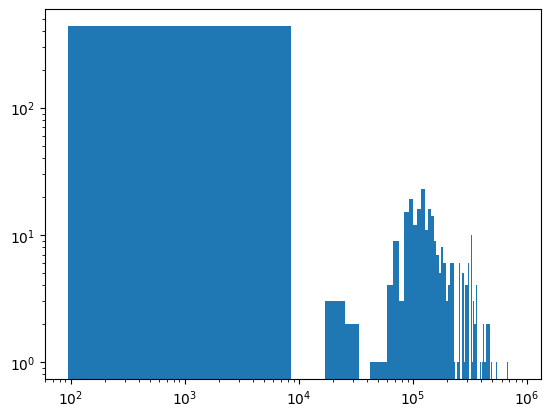